(10, 2)
[[-7.23930125  8.23969941]
 [-4.50558051 -6.26431075]
 [-5.01938718 -6.0636779 ]
 [-4.07511453 -6.13677776]
 [-8.40616825  8.71219627]
 [ 8.43393806 -3.39520289]
 [ 7.71696806 -2.36398815]
 [-4.67434155 -5.92635427]
 [-7.82369027  9.72696293]
 [ 8.17660825 -2.48193613]]
[2 0 0 0 2 1 1 0 2 1]


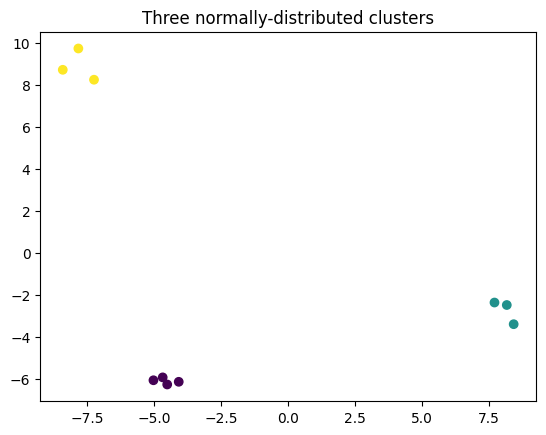

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets import make_blobs

n_clusters = 3
X, y = make_blobs(n_samples=10, centers=n_clusters, cluster_std=0.5)#, random_state=0)

labels, counts = np.unique(y, return_counts=True)

print(X.shape)
print(X[: 10])
print(y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Three normally-distributed clusters")
plt.show()

In [137]:
true_centroids = [[0,0] for _ in range(n_clusters)]
for i in range(len(X)):
    true_centroids[y[i]] += X[i]
for k in range(n_clusters):
    true_centroids[k] /= counts[k]

true_centroids


[array([-4.56860594, -6.09778017]),
 array([ 8.10917145, -2.74704239]),
 array([-7.82305326,  8.89295287])]

In [ ]:
def dist(x1, x2):
    s = 0
    for i in range(len(x1)):
        s += (x1[i] - x2[i])**2
    return np.sqrt(s)

def dist_(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def kmeans_alamano(X, n_clusters, max_iter = 5, tol = 1e-4):

    # Random initialization of the clusters
    # clusters = [[] for _ in range(n_clusters)]
    # for x_i in X:
    #     k = random.randrange(n_clusters)
    #     clusters[k].append(x_i)
    X_ = X.copy()
    np.random.shuffle(X_)
    clusters = np.array_split(X_, n_clusters)

    # Initiziales centroids
    centroids = [[0,0] for _ in range(n_clusters)]
    prev_centroids = [[0,0] for _ in range(n_clusters)]

    for _ in range(max_iter):
        
        # Computes centroids
        for k in range(n_clusters):
            centroids_k = np.zeros(2)
            for x_ik in clusters[k]:
                centroids_k += x_ik
            centroids[k] = centroids_k/len(clusters[k])
            
        # Computes clusters according to the new centroids
        clusters = [[] for _ in range(n_clusters)]
        for x_i in X:
            for k in range(n_clusters):
                k_min = 0
                dist_min = np.inf
                dist_to_k = dist(x_i, centroids[k])
                print(dist_to_k)
                print(dist_to_k < dist_min)
                if dist_to_k < dist_min:
                    k_min = k
                    dist_min = dist_to_k
                    print("a")
            print(k_min)
            clusters[k_min].append(x_i)
            
        # Computes distance from previous centroids to the new one
        dist_centroids = 0
        for c_k, pc_k in zip(centroids, prev_centroids):
            dist_centroids += dist(c_k, pc_k)
        if dist_centroids < tol:
            break
        
        # Keeps previous centroids in memory
        prev_centroids = centroids.copy()

    return centroids, clusters

kmeans_alamano(X, n_clusters)
#centroids, clusters = kmeans_alamano(X,n_clusters)

#plt.scatter(clusters[:, 0], clusters[:, 1])
#plt.title("Three normally-distributed clusters")
#plt.show()

11.022735997260295
True
a
16.543289106615376
True
a
4.165616254752458
True
a
2
5.245453734036707
True
a
8.685587108091786
True
a
10.60921308717433
True
a
2
5.320810309185886
True
a
9.13549047027273
True
a
10.313838595853003
True
a
2
4.951930984473725
True
a
8.236777043967763
True
a
10.585898679138566
True
a
2
12.005423039979153
True
a
17.68594703845318
True
a
4.893624961648793
True
a
2
10.780729124488875
True
a
4.593201873369904
True
a
16.94988934946683
True
a
2
9.938802770332273
True
a
4.1726410302067425
True
a
15.862443128448117
True
a
2
5.0257666392320175
True
a
8.768571960424806
True
a
10.243459510940642
True
a
2
12.613502760953537
True
a
18.04612331751088
True
a
5.724296999353536
True
a
2
10.406803249004776
True
a
4.5578454315926775
True
a
16.33044224553832
True
a
2
nan
False
nan
False
10.405889937434633
True
a
2
nan
False
nan
False
6.306884456098224
True
a
2
nan
False
nan
False
6.375466619979274
True
a
2
nan
False
nan
False
6.01272002798335
True
a
2
nan
False
nan
False
11.4475582

/tmp/ipykernel_34039/2706708308.py:32: RuntimeWarning: invalid value encountered in divide
  centroids[k] = centroids_k/len(clusters[k])


([array([nan, nan]), array([nan, nan]), array([-1.74160692, -0.59533892])],
 [[],
  [],
  [array([-7.23930125,  8.23969941]),
   array([-4.50558051, -6.26431075]),
   array([-5.01938718, -6.0636779 ]),
   array([-4.07511453, -6.13677776]),
   array([-8.40616825,  8.71219627]),
   array([ 8.43393806, -3.39520289]),
   array([ 7.71696806, -2.36398815]),
   array([-4.67434155, -5.92635427]),
   array([-7.82369027,  9.72696293]),
   array([ 8.17660825, -2.48193613])]])